# Imports

In [84]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,
                                     Dropout,Input,GlobalMaxPooling1D,Embedding,TextVectorization,LayerNormalization,MultiHeadAttention)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [85]:
! wget https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py

--2023-09-12 07:03:15--  https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7752 (7.6K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]   7.57K  --.-KB/s    in 0s      

2023-09-12 07:03:15 (81.4 MB/s) - ‘helper_functions.py.1’ saved [7752/7752]



In [86]:
from helper_functions import (make_confusion_matrix, plot_loss_curves, calculate_results, plot_class_accuracy,
                              plot_prediction_confidence_histogram, create_tensorboard_callback)

In [ ]:
loss, top_k_accuracy, val_loss, val_top_k_accuracy

In [139]:
def plot_loss_curves(history):
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['top_k_accuracy'])
    val_accuracy = np.array(history.history['val_top_k_accuracy'])

    epochs = range(len(history.history['loss']))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_top_5_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_top_5_accuracy', marker='o')

    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

# Data Downloading

In [4]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d arashnic/mind-news-dataset
! unzip "/content/mind-news-dataset.zip" -d "/content/dataset/"

 92% 57.0M/61.7M [00:03<00:00, 20.2MB/s]
100% 61.7M/61.7M [00:03<00:00, 17.8MB/s]
Archive:  /content/mind-news-dataset.zip
  inflating: /content/dataset/MINDsmall_train/behaviors.tsv  
  inflating: /content/dataset/MINDsmall_train/entity_embedding.vec  
  inflating: /content/dataset/MINDsmall_train/news.tsv  
  inflating: /content/dataset/MINDsmall_train/relation_embedding.vec  
  inflating: /content/dataset/news.tsv/news.tsv  


# Data Preparation

In [87]:
df = pd.read_csv('/content/dataset/news.tsv/news.tsv', header=None, sep='\t')
df.columns = ['News ID', "Category", "SubCategory", "Title", "Abstract", "URL", "Title Entities", "Abstract Entities "]
df = df[['Category', 'Title']]

In [88]:
df.head(5)

,Category,Title
0,lifestyle,"The Brands Queen Elizabeth, Prince Charles, an..."
1,health,50 Worst Habits For Belly Fat
2,news,The Cost of Trump's Aid Freeze in the Trenches...
3,health,I Was An NBA Wife. Here's How It Affected My M...
4,health,"How to Get Rid of Skin Tags, According to a De..."


In [89]:
df.isnull().sum()

Category    0
Title       0
dtype: int64

In [90]:
df.duplicated().sum()

750

In [91]:
df.drop_duplicates(inplace=True)

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50532 entries, 0 to 51281
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  50532 non-null  object
 1   Title     50532 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [93]:
# classes = df['Category'].value_counts().index.tolist()[:10]
# df = df[df['Category'].isin(classes)]

In [94]:
df.drop(df[(df['Category'] == 'middleeast') | (df['Category'] == 'northamerica')].index, inplace=True)

In [95]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+', ' ', text) # Remove URL from string
    text = re.sub('<.*?>+', ' ', text) # Remove HTML Tags
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # Replace Punctuation with space
    text = re.sub('\n', ' ', text) # Replace NewLine with space
    text = re.sub(r'\w*\d\w*', ' ', text) # Remove alphanumeric
    text = text.replace('-', ' ')
    text = ' '.join(text.split())  # Strip extra spaces
    return text

In [96]:
clean_text("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this ** ?????? ?movie! would you?<br> <br /><br />T")

'in the movie man called tévèz went to a friend’s pl ce and they had a tensed discussion i don’t love this movie would you t'

# BaseLine Model

In [97]:
X_train, X_test, y_train, y_test = train_test_split(df['Title'], df['Category'], test_size=0.20)

In [98]:
train_sentences = X_train.apply(clean_text)
test_sentences = X_test.apply(clean_text)
train_sentences = train_sentences.tolist()
test_sentences = test_sentences.tolist()

In [99]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [100]:
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(y_train)
test_labels = label_encoder.transform(y_test)

In [195]:
class_labels = label_encoder.classes_.tolist()
num_classes = len(class_labels)
print("Number of classes in dataset is:", num_classes)
print("Labels in dataset are:", class_labels)

Number of classes in dataset is: 15
Labels in dataset are: ['autos', 'entertainment', 'finance', 'foodanddrink', 'health', 'kids', 'lifestyle', 'movies', 'music', 'news', 'sports', 'travel', 'tv', 'video', 'weather']


In [102]:
print("Training Examples:")
len(train_sentences), len(train_labels)

Training Examples:


(40423, 40423)

In [103]:
print("Test Examples:")
len(test_sentences), len(test_labels)

Test Examples:


(10106, 10106)

# Baseline model

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

baseline_model = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

baseline_model.fit(X = train_sentences,
                   y = train_labels)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [105]:
baseline_model.score(X = test_sentences,
                     y = test_labels)

0.5960815357213537

In [106]:
baseline_preds = baseline_model.predict(test_sentences)
baseline_results = calculate_results(y_true = test_labels,
                                     y_pred = baseline_preds)
baseline_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 59.60815357213537,
 'precision': 0.647324334923255,
 'recall': 0.5960815357213537,
 'f1': 0.494234864447162}

# Sentence Tokenization

In [107]:
sentences_length = [len(sentence.split()) for sentence in df['Title']]
avg_sentence_length = np.mean(sentences_length)
print(avg_sentence_length)

10.774565101228998


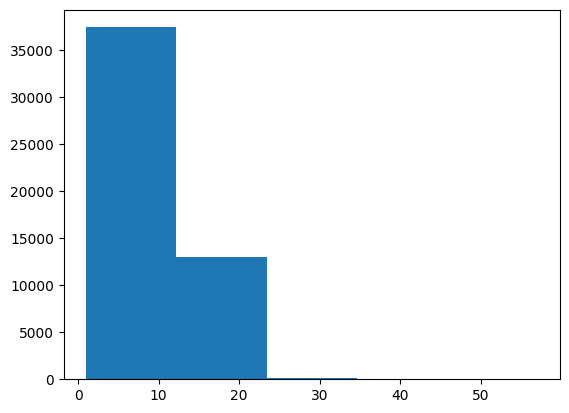

In [108]:
plt.hist(sentences_length, bins=5);

In [109]:
output_sequence_length = int(np.percentile(sentences_length, 95))
print(output_sequence_length)

16


In [110]:
max_tokens = 20000
vectorize_layer = TextVectorization(max_tokens = max_tokens,
                                    output_mode = 'int',
                                    standardize = 'lower_and_strip_punctuation',
                                    output_sequence_length = 16)

vectorize_layer.adapt(df['Title'])

In [111]:
random_sentence = random.choice(train_sentences)
print('Sentence:', random_sentence)
print('Length of sentence:', len(random_sentence.split()))
print('Vectorized_Form:', vectorize_layer([random_sentence]))

Sentence: go free this week with these no cost events in san antonio
Length of sentence: 12
Vectorized_Form: tf.Tensor(
[[ 252  199   18   28   10  106   47  861 1127    3  257  694    0    0
     0    0]], shape=(1, 16), dtype=int64)


In [112]:
text_vocab = vectorize_layer.get_vocabulary()
print("Total number of words in vocalbuary", len(text_vocab))
print("The Top Most 5 common words in vocalbuary:", text_vocab[:5])
print("The Least Most 5 common words in vocalbuary:", text_vocab[-5:])

Total number of words in vocalbuary 20000
The Top Most 5 common words in vocalbuary: ['', '[UNK]', 'to', 'in', 'the']
The Least Most 5 common words in vocalbuary: ['ardsley', 'archive', 'archies', 'archdale', 'arc']


In [113]:
vectorize_layer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None, None),
 'max_tokens': 20000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 16,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 20000}

In [114]:
news_label = df['Category'].value_counts().index
values = df['Category'].value_counts().values
total_samples = 49696
weights = {}
for label, value in zip(news_label, values):
  weights[class_labels.index(label)] = total_samples / value

print("Weights:", weights)

Weights: {9: 3.1917790622992936, 10: 3.5163093469185593, 2: 16.1193642555952, 3: 19.634926906361123, 6: 20.185215272136475, 11: 21.301328761251607, 13: 24.194741966893865, 14: 24.76133532635775, 4: 26.49040511727079, 0: 30.48834355828221, 12: 56.090293453724605, 8: 65.13237221494103, 7: 82.41459369817579, 1: 85.53528399311531, 5: 2923.294117647059}


In [115]:
train_labels_one_hot = to_categorical(train_labels, num_classes=num_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes=num_classes)

In [116]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [117]:
train_dataset = train_dataset.shuffle(buffer_size=4029).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=4029).prefetch(buffer_size=tf.data.AUTOTUNE)

In [118]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(15,), dtype=tf.float32, name=None))>

In [119]:
for sentences, labels in train_dataset.take(1):
    print("Sentence = ", sentences)
    print("Labels = ", labels)

Sentence =  tf.Tensor(b'richard engel ukraine didn t want to get dragged into the impeachment inquiry', shape=(), dtype=string)
Labels =  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(15,), dtype=float32)


In [120]:
train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(64)

In [121]:
for sentences, labels in train_dataset.take(1):
  for i in range(3):
    print("Sentence = ", sentences[i])
    print("Labels = ", labels[i])

Sentence =  tf.Tensor(b'a kc restaurant could be honored as the hottest new concept in kansas see the nominees', shape=(), dtype=string)
Labels =  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(15,), dtype=float32)
Sentence =  tf.Tensor(b'targa resources finds buyer for permian basin crude oil assets', shape=(), dtype=string)
Labels =  tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(15,), dtype=float32)
Sentence =  tf.Tensor(b'cbs evening news headlines for friday november', shape=(), dtype=string)
Labels =  tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(15,), dtype=float32)


# Modeling

## Transformers

### Embeddings

In [173]:
def positional_encoding(model_size, SEQUENCE_LENGTH):
  output = []
  for pos in range(SEQUENCE_LENGTH):
    PE = np.zeros((model_size))
    for i in range(model_size):
      if i%2 == 0:
        PE[i] = np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i] = np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE, axis=0))
  out = tf.concat(output, axis=0)
  out = tf.expand_dims(out, axis=0)
  return tf.cast(out, dtype=tf.float32)

In [174]:
positional_encoding(256, 14).shape

TensorShape([1, 14, 256])

In [175]:
@tf.keras.utils.register_keras_serializable()
class Embeddings(Layer):
  def __init__(self, sequence_length=None, vocab_size=None, embed_dim=None, **kwargs):
    super(Embeddings, self).__init__(**kwargs)
    self.token_embeddings = Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

  def build(self, input_shape):
    super(Embeddings, self).build(input_shape)

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions = positional_encoding(self.embed_dim, self.sequence_length)
    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

  def get_config(self):
    config = super(Embeddings, self).get_config()
    config.update({
        'sequence_length': self.sequence_length,
        'vocab_size': self.vocab_size,
        'embed_dim': self.embed_dim,
    })
    return config

In [176]:
@tf.keras.utils.register_keras_serializable()
class Encoder(Layer):
  def __init__(self, embed_dim=None, dense_dim=None, num_heads=None, **kwargs):
    super(Encoder, self).__init__(**kwargs)
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.attention = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
    self.dense_proj = tf.keras.Sequential(
        [Dense(dense_dim, activation='relu'),
         Dense(embed_dim)])
    self.layernorm_1 = LayerNormalization()
    self.layernorm_2 = LayerNormalization()
    self.supports_masking = True

  def build(self, input_shape):
    super(Encoder, self).build(input_shape)

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

  def call(self, inputs, mask=None):
    if mask is not None:
      mask1 = mask[:, :, tf.newaxis]
      mask2 = mask[:, tf.newaxis, :]
      padding_mask = tf.cast(mask1 & mask2, dtype="int32")

    attention_output = self.attention(query=inputs, key=inputs, value=inputs, attention_mask=padding_mask)
    proj_input = self.layernorm_1(inputs + attention_output)
    proj_output = self.dense_proj(proj_input)
    return self.layernorm_2(proj_input + proj_output)

  def get_config(self):
    config = super(Encoder, self).get_config()
    config.update({
        'embed_dim': self.embed_dim,
        'num_heads': self.num_heads,
        'dense_dim': self.dense_dim,
    })
    return config

### Encoder

### Transformer Model

In [177]:
num_layers = 1
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.4
vocab_size = 20000
sequece_len = 16

In [178]:
encoder_input = Input(shape=[], dtype="string", name="input")
x = vectorize_layer(encoder_input)
x = Embeddings(sequece_len, vocab_size, d_model)(x)

for _ in range(num_layers):
  x = Encoder(d_model, dff, num_heads)(x)

x = Dropout(rate=0.4)(x)
x = Flatten()(x)
output_layer = Dense(num_classes, activation="softmax")(x)

transformer = Model(encoder_input, output_layer, name="transformer")
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None,)]                 0         
                                                                 
 text_vectorization_1 (Text  (None, 16)                0         
 Vectorization)                                                  
                                                                 
 embeddings_4 (Embeddings)   (None, 16, 128)           2560000   
                                                                 
 encoder_9 (Encoder)         (None, 16, 128)           659712    
                                                                 
 dropout_19 (Dropout)        (None, 16, 128)           0         
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                       

## Training

In [179]:
def top_k_accuracy(y_true, y_pred, k=5):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=k)

In [180]:
transformer.compile(loss = categorical_crossentropy,
                    optimizer = Adam(),
                    metrics = [top_k_accuracy])

In [181]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [185]:
history = transformer.fit(train_dataset,
                          validation_data = test_dataset,
                          class_weight = weights,
                          callbacks=[reduce_lr, early_stopping],
                          epochs = 100)

Epoch 1/100
632/632 [==============================] - 9s 14ms/step - loss: 41.9458 - top_k_accuracy: 0.4203 - val_loss: 2.8488 - val_top_k_accuracy: 0.4885 - lr: 0.0010
Epoch 2/100
632/632 [==============================] - 7s 11ms/step - loss: 37.1450 - top_k_accuracy: 0.6288 - val_loss: 3.3948 - val_top_k_accuracy: 0.4253 - lr: 0.0010
Epoch 3/100
632/632 [==============================] - 8s 13ms/step - loss: 34.3463 - top_k_accuracy: 0.6983 - val_loss: 2.4052 - val_top_k_accuracy: 0.6482 - lr: 0.0010
Epoch 4/100
632/632 [==============================] - 9s 14ms/step - loss: 31.7831 - top_k_accuracy: 0.7526 - val_loss: 2.3228 - val_top_k_accuracy: 0.7050 - lr: 0.0010
Epoch 5/100
632/632 [==============================] - 7s 11ms/step - loss: 28.3910 - top_k_accuracy: 0.8110 - val_loss: 2.0846 - val_top_k_accuracy: 0.7597 - lr: 0.0010
Epoch 6/100
632/632 [==============================] - 7s 11ms/step - loss: 25.4390 - top_k_accuracy: 0.8442 - val_loss: 1.9807 - val_top_k_accuracy: 

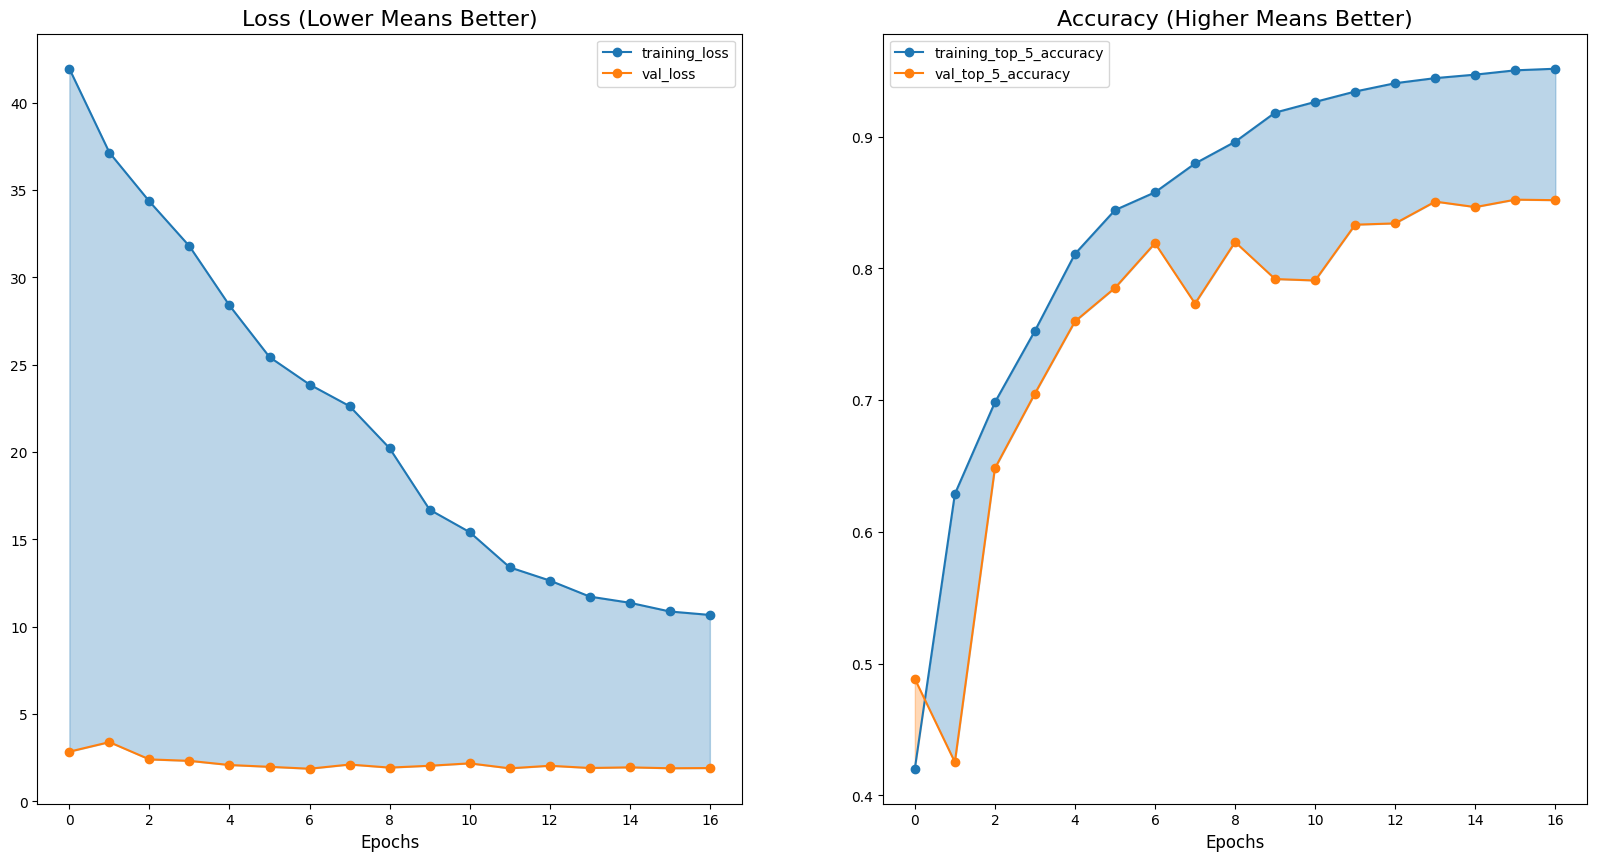

In [186]:
plot_loss_curves(history)

# Model Evaluation

In [187]:
true_labels = []
predicted_labels = []
text = []

for batch_news, batch_labels in test_dataset:
    batch_predictions = transformer.predict(batch_news)

    batch_predicted_labels = np.argmax(batch_predictions, axis=1)
    batch_labels = np.argmax(batch_labels, axis=1)

    text.extend(batch_news)
    true_labels.extend(batch_labels)
    predicted_labels.extend(batch_predicted_labels)


true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

2/2 [==============================] - 0s 9ms/step


In [190]:
model_results = calculate_results(y_true = true_labels,
                                  y_pred = predicted_labels)
model_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 42.519295468038784,
 'precision': 0.49423773791646364,
 'recall': 0.42519295468038787,
 'f1': 0.4330823244222968}

Confusion Matrix


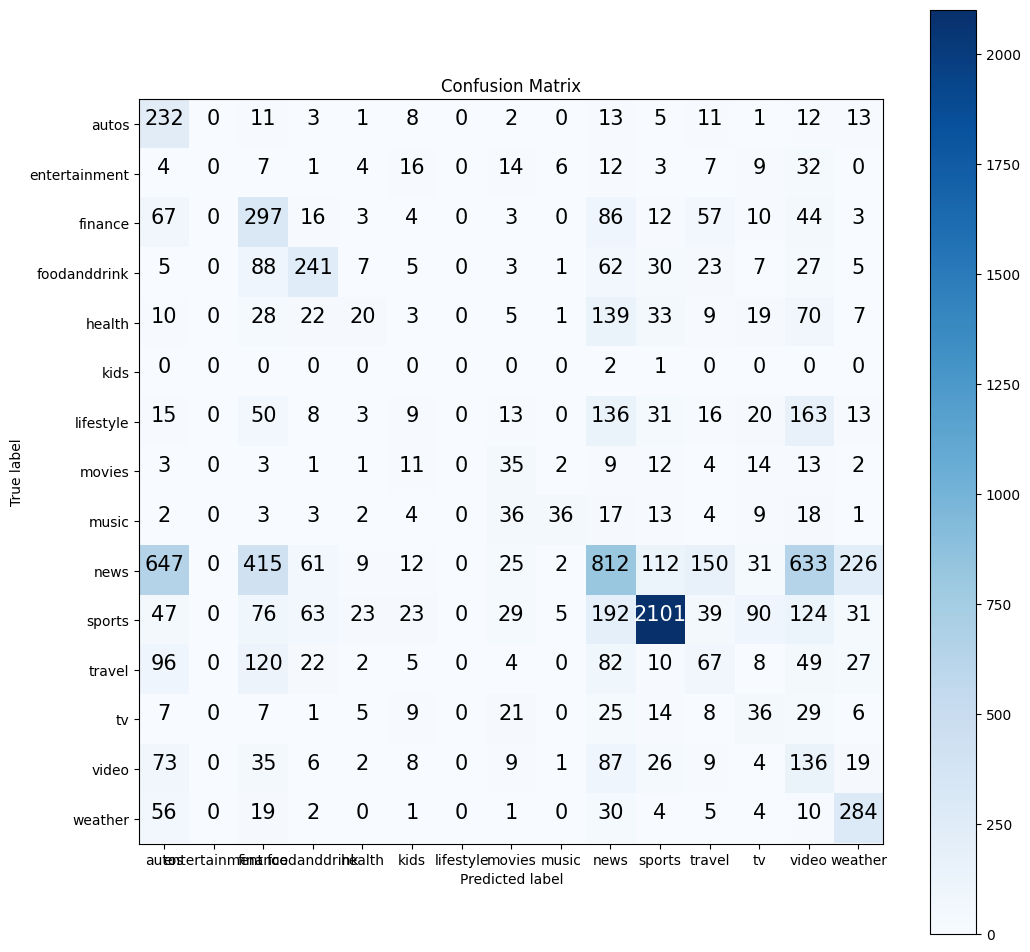

In [203]:
print("Confusion Matrix")
make_confusion_matrix(y_true = true_labels,
                      y_pred = predicted_labels,
                      classes = class_labels,
                      figsize = (12, 12))

In [201]:
print("Classification Report")
print(classification_report(true_labels, predicted_labels))

Classification Report
              precision    recall  f1-score   support

           0       0.18      0.74      0.29       312
           1       0.00      0.00      0.00       115
           2       0.26      0.49      0.34       602
           3       0.54      0.48      0.51       504
           4       0.24      0.05      0.09       366
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00       477
           7       0.17      0.32      0.23       110
           8       0.67      0.24      0.36       148
           9       0.48      0.26      0.34      3135
          10       0.87      0.74      0.80      2843
          11       0.16      0.14      0.15       492
          12       0.14      0.21      0.17       168
          13       0.10      0.33      0.15       415
          14       0.45      0.68      0.54       416

    accuracy                           0.43     10106
   macro avg       0.28      0.31      0.26     10106
weig

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ClassWise Accuracy


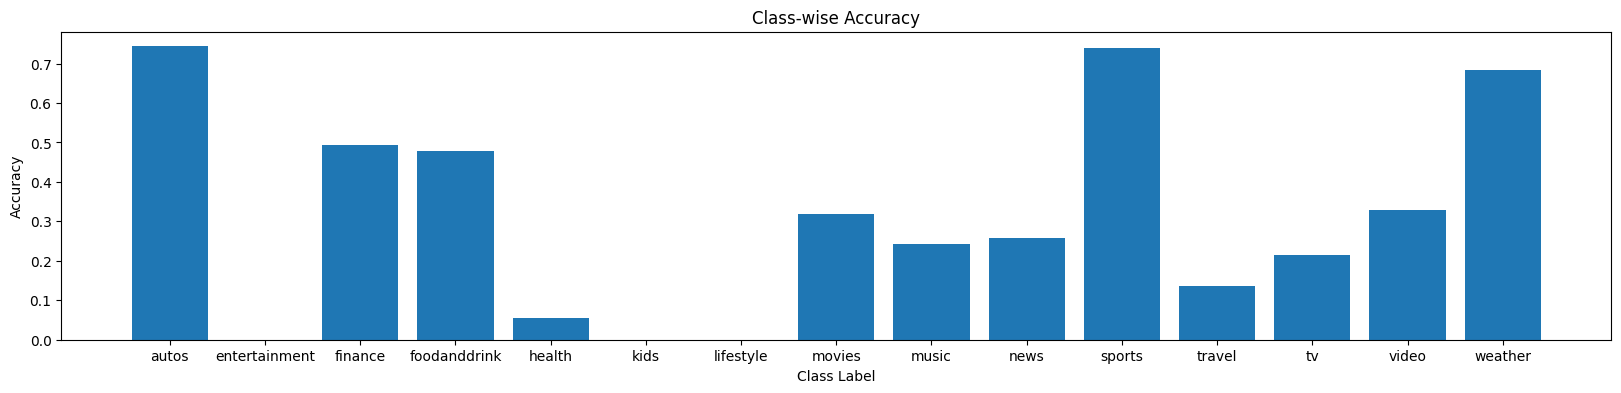

In [204]:
print("ClassWise Accuracy")
plot_class_accuracy(num_classes,
                    y_true = true_labels,
                    y_pred = predicted_labels,
                    classes = class_labels,
                    figsize = (20, 4))

# Saving a model

In [206]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [205]:
transformer.save("transformer_model")
loaded_transformer = tf.keras.models.load_model("transformer_model", custom_objects={'top_k_accuracy': top_k_accuracy})

In [208]:
%cp -av /content/transformer_model /content/drive/MyDrive/Different_News_Category_Classification

'/content/transformer_model' -> '/content/drive/MyDrive/Different_News_Category_Classification'
'/content/transformer_model/variables' -> '/content/drive/MyDrive/Different_News_Category_Classification/variables'
'/content/transformer_model/variables/variables.index' -> '/content/drive/MyDrive/Different_News_Category_Classification/variables/variables.index'
'/content/transformer_model/variables/variables.data-00000-of-00001' -> '/content/drive/MyDrive/Different_News_Category_Classification/variables/variables.data-00000-of-00001'
'/content/transformer_model/assets' -> '/content/drive/MyDrive/Different_News_Category_Classification/assets'
'/content/transformer_model/fingerprint.pb' -> '/content/drive/MyDrive/Different_News_Category_Classification/fingerprint.pb'
'/content/transformer_model/keras_metadata.pb' -> '/content/drive/MyDrive/Different_News_Category_Classification/keras_metadata.pb'
'/content/transformer_model/saved_model.pb' -> '/content/drive/MyDrive/Different_News_Category_C

In [209]:
test_data = tf.data.Dataset.from_tensor_slices([["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "],
                                              ["very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, so in all i didn't like this movie "],])
class_labels = ['autos', 'entertainment', 'finance', 'foodanddrink', 'health', 'kids', 'lifestyle', 'movies', 'music', 'news', 'sports', 'travel', 'tv', 'video', 'weather']
model_pred_probs = loaded_transformer.predict(test_data)
model_preds = tf.argmax(model_pred_probs, axis=1)
[class_labels[pred] for pred in model_preds]

2/2 [==============================] - 1s 10ms/step


['music', 'music']

# Hugging Face

In [210]:
! pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 5.6 MB/s eta 0:00:00


In [211]:
from huggingface_hub import notebook_login
notebook_login()

In [213]:
path = "/content/drive/MyDrive/Different_News_Category_Classification"
model = tf.keras.models.load_model(path, custom_objects={'top_k_accuracy': top_k_accuracy})

In [214]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(model = model, repo_id = "DriveMyScream/Different_News_Category_Classification")

fingerprint.pb:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

keras_metadata.pb:   0%|          | 0.00/27.0k [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/832k [00:00<?, ?B/s]

'https://huggingface.co/DriveMyScream/Different_News_Category_Classification/tree/main/'

In [216]:
from huggingface_hub import from_pretrained_keras
loaded_model = from_pretrained_keras("DriveMyScream/Different_News_Category_Classification", custom_objects={'top_k_accuracy': top_k_accuracy})

config.json not found in HuggingFace Hub.


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [217]:
test_data = tf.data.Dataset.from_tensor_slices([["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "],
                                              ["very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, so in all i didn't like this movie "],])
class_labels = ['autos', 'entertainment', 'finance', 'foodanddrink', 'health', 'kids', 'lifestyle', 'movies', 'music', 'news', 'sports', 'travel', 'tv', 'video', 'weather']
model_pred_probs = loaded_model.predict(test_data)
model_preds = tf.argmax(model_pred_probs, axis=1)
[class_labels[pred] for pred in model_preds]

2/2 [==============================] - 1s 10ms/step


['sports', 'music']

# Tensorflow Lite

In [219]:
import tensorflow as tf

path = "/content/transformer_model"
model = tf.keras.models.load_model(path, custom_objects={'top_k_accuracy': top_k_accuracy})

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "Different_News_Category_Classification.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

In [220]:
model_path = "/content/Different_News_Category_Classification.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

class_labels = ['autos', 'entertainment', 'finance', 'foodanddrink', 'health', 'kids', 'lifestyle', 'movies', 'music', 'news', 'sports', 'travel', 'tv', 'video', 'weather']

def predict_tflite(text):
    text = text.encode('utf-8')
    text_data = np.array([text], dtype=object)
    interpreter.set_tensor(input_details[0]['index'], text_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data)
    return class_labels[predicted_class]

test_data = ["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But at least this movie recreates these scenes!"]
tflite_predictions = [predict_tflite(text) for text in test_data]
for text, prediction in zip(test_data, tflite_predictions):
    print(f"Text: {text}")
    print(f"Prediction: {prediction}")

Text: this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But at least this movie recreates these scenes!
Prediction: sports
